In [1]:
import torch 
from torch import nn 
import torchvision as tv 
from torch.optim import Adam 
from torchsummary import summary

c:\Users\Samba\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Samba\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Choosing the preferred computing platform

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device,torch.cuda.get_device_name()

(device(type='cuda'), 'NVIDIA GeForce GTX 1050')

In [3]:
trainset = tv.datasets.ImageFolder('../mnist_png/training/',transform=tv.transforms.Compose([tv.transforms.ToTensor()]))
testset = tv.datasets.ImageFolder('../mnist_png/testing/',transform=tv.transforms.Compose([tv.transforms.ToTensor()]))
trainset.classes


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [4]:
valset, testset = torch.utils.data.random_split(testset,[5000,5000])

In [5]:
class CNNET(nn.Module):
    def __init__(self):
        super(CNNET,self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(3,16,5), # 28-5+1
            nn.ReLU(), #24
            nn.MaxPool2d(2,2), # 12

            nn.Conv2d(16,32,3), # 12+1-3
            nn.ReLU(), # 10
            nn.MaxPool2d(2,2), # 5
            

            nn.Conv2d(32,64,5), # 11-3+1
            nn.ReLU(),

            nn.Conv2d(64,10,1)   
        )
    
    def forward(self,x):
        x = self.layer(x)
        return x

In [6]:
model = CNNET().to(device)
model

CNNET(
  (layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [7]:
summary(model.cuda(),(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]           1,216
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4           [-1, 32, 10, 10]           4,640
              ReLU-5           [-1, 32, 10, 10]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
              ReLU-8             [-1, 64, 1, 1]               0
            Conv2d-9             [-1, 10, 1, 1]             650
Total params: 57,770
Trainable params: 57,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.21
Params size (MB): 0.22
Estimated Total Size (MB): 0.44
---------------------------------------------

### Select Learning Rate, epochs, and Loss function

In [8]:
learningRate = 3e-4
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = learningRate)

In [9]:
batch=256
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch,num_workers=4,shuffle=True)
valloader = torch.utils.data.DataLoader(valset,batch_size=batch,num_workers=4,shuffle=True)

testloader = torch.utils.data.DataLoader(testset,batch_size=batch,shuffle=False)

In [10]:
from tqdm.notebook import tqdm

In [11]:
def test(model,lossFunc,testloader,device):
    '''
    model: model (CNN) architecture object
    lossFunc: Loss Function / criterion 
    testloader: PyTorch SPECIFIC object of DataLoader class | torch.utils.data.DataLoader 
    device: computing platform CPU/GPU
    '''
    model.eval() #setting the model in evaluation mode
    total = 0
    correctpreds = 0
    running_loss = 0 

    with torch.no_grad():

        for x,y in tqdm(testloader):
            out = model(x.to(device))
            out = torch.flatten(out,start_dim=1)
            loss = lossFunc(out,y.to(device))
            running_loss +=loss.item()
            
            total += y.size(0) # size per batch
            # totalSize = batch_size * len(test_loader) = total_testSet_size

            preds = out.argmax(dim=1).cpu().detach()

            correctpreds +=(preds==y.cpu().detach()).sum().item()

    test_loss = running_loss/len(testloader) #  sum(per batch loss)/total_num_batch
    test_accuracy = 100*(correctpreds/total)
    return test_loss,test_accuracy
    



In [12]:
def training(model,device,optimizer,criterion,trainloader):
    """
    model: model (CNN) architecture object
    criterion: Loss Function / criterion 
    optimizer: selected optimization algorithm 
    trainloader: PyTorch SPECIFIC object of DataLoader class | torch.utils.data.DataLoader 
    device: computing platform CPU/GPU
    """
    model.train()
    total_train = 0 
    correct_train = 0
    running_trainloss = 0
    
    for x,y in tqdm(trainloader):
        output = model(x.to(device))
        output = torch.flatten(output,start_dim=1)
        # print(output.shape)
        loss = criterion(output,y.to(device))

        running_trainloss+= loss.item()
        total_train += y.size(0)
        preds = output.argmax(dim=1).cpu().detach()
        correct_train += (preds==y.cpu().detach()).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = 100*(correct_train/total_train)
    avgloss = running_trainloss/len(trainloader)

    return avgloss,accuracy


In [13]:

trainLosses = []
trainAccuracy = []
valLosses = []
valAccuracy = []

for epoch in range(Epochs):
    print(f'Epoch {epoch+1}/{Epochs}')
    trainL,trainA = training(model,device,optimizer,criterion,trainloader)
    trainLosses.append(trainL)
    trainAccuracy.append(trainA)
    valL,valA = test(model,criterion,testloader,device)
    valLosses.append(valL)
    valAccuracy.append(valA)

    

Epoch 1/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/20


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

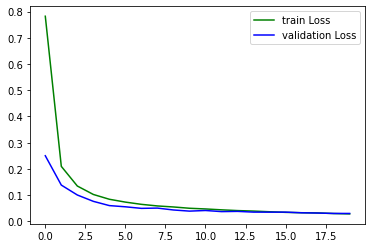

In [14]:
import matplotlib.pyplot as plt 
%matplotlib inline
epochs = range(20)
plt.plot(epochs,trainLosses,'g',label='train Loss')
plt.plot(epochs,valLosses,'b',label='validation Loss')
plt.legend()
plt.show()

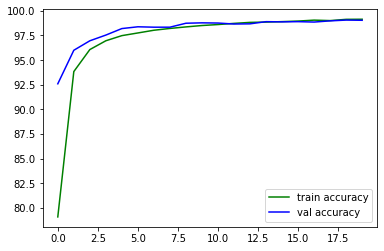

In [15]:
plt.plot(epochs,trainAccuracy,'g',label='train accuracy')
plt.plot(epochs,valAccuracy,'b',label='val accuracy')
plt.legend()
plt.show()

In [16]:
trainAccuracy[-1],valAccuracy[-1]

(99.125, 99.02)

In [18]:
trainLosses[-1],valLosses[-1]

(0.02843032422217917, 0.030198615952394904)

In [17]:
test(model,criterion,testloader,device)

  0%|          | 0/20 [00:00<?, ?it/s]

(0.030198615952394904, 99.02)